### メインモデルファイル

【実行順序】<br>
※実行毎にRestart, 変数指定をしてください。<br>
①BERTモデルの特徴量を作成（B_BERT_clsファイル）してください。<br>
　計18回(span x3, col x3, model x2)<br>
②スパンモデルの特徴量を作成（このファイル）してください。<br>
　計4回（span x2, model x2）<br>
③メインモデルを作成を実行してください。<br>

【このファイルでの変数指定順序】<br>
① span: 365, model: cb<br>
② span: 365, model: lgb<br>
③ span: 730, model: cb<br>
④ span: 730, model: lgb<br>
⑤ span: 0, model: cb<br>

### 目次

・ディレクトリ構造<br>
・ライブラリインストール<br>
・変数指定<br>
・定数<br>
・カラム内容<br>
・データ読み込み<br>
・前処理・EDA（探索的データ分析）<br>
　・初回掲載年、経過日数カラム<br>
　・span別にデータ抽出<br>
　・トップトークンリスト作成<br>
　・カラム絞り込み<br>
　・カウントカラム<br>
　・BERT特徴量カラム<br>
　・スパンモデル特徴量カラム<br>
・訓練データ作成<br>
・訓練<br>
・評価（参考：最終モデルのみ）<br>
・特徴量重要度<br>
・モデル出力の特徴量化（スパンモデルのみ）<br>
・テストデータ予測<br>
・テストデータ予測値の特徴量化（スパンモデルのみ）<br>
・提出<br>

### ディレクトリ構造

In [ ]:
"""
BASE_DIR
    ├data_explanation.xlsx
    ├train.csv
    ├test.csv
    └sample_submission.csv
"""

### ライブラリインストール

In [1]:
import collections
import datetime
import pickle
import re
import unicodedata
import warnings

import catboost as cb
import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from transformers import BertJapaneseTokenizer

# plt.style.use('dark_background')
warnings.filterwarnings('ignore')

### 変数指定

In [2]:
# BASE_DIR = r'D:/Data/Nishika/Extending_bookmarks/data/'
BASE_DIR = r''
span = 0 # 全て:0, 365:365日(1年), 730:730日(2年)
model_type = 'cb' # CatBoost:'cb', LightBGM:'lgb'

### 定数

In [3]:
URL_PATTERN = re.compile(r'http[\w:./\d]+') # URL
DATE_PATTERN = re.compile(r'\d+/\d+/\d+') # DATE
HIRAGANA_PATTERN = re.compile('[\u3041-\u309F]+') # ひらがな
KATAKANA_PATTERN = re.compile('[\u30A1-\u30FF]+') # カタカナ
EIGO_PATTERN = re.compile('[\u0041-\u005A]+|[\u0061-\u007A]+') # 英語
SUUZI_PATTERN = re.compile('[\u0030-\u0039]+') # 数字
KANZI_PATTERN = regex.compile(r'\p{Script=Han}+') # 漢字
EMOZI_PATTERN = regex.compile(r'\p{Emoji_Presentation=Yes}+') # 絵文字

MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

###　カラム内容

In [4]:
pd.set_option('display.max_colwidth', None)
pd.read_excel(BASE_DIR + 'data_explanation.xlsx', sheet_name=1)

,カラム名,内容
0,ncode,Nコード（小説ID）
1,general_firstup,初回掲載日
2,title,小説名
3,story,小説のあらすじ
4,keyword,キーワード
5,userid,作者のユーザーID
6,writer,作者名
7,biggenre,大ジャンル\n1:恋愛\n2:ファンタジー\n3:文芸\n4:SF\n99:その他\n98:ノンジャンル
8,genre,ジャンル\n101:異世界〔恋愛〕\n102:現実世界〔恋愛〕\n201:ハイファンタジー〔ファンタジー〕\n202:ローファンタジー〔ファンタジー〕\n301:純文学〔文芸〕\n302:ヒューマンドラマ〔文芸〕\n303:歴史〔文芸〕\n304:推理〔文芸〕\n305:ホラー〔文芸〕\n306:アクション〔文芸〕\n307:コメディー〔文芸〕\n401:VRゲーム〔SF〕\n402:宇宙〔SF〕\n403:空想科学〔SF〕\n404:パニック〔SF〕\n9901:童話〔その他〕\n9902:詩〔その他〕\n9903:エッセイ〔その他〕\n9904:リプレイ〔その他〕\n9999:その他〔その他〕\n9801:ノンジャンル〔ノンジャンル〕
9,novel_type,連載の場合は1、短編の場合は2


### データ読み込み

In [5]:
raw = pd.read_csv(BASE_DIR + 'train.csv')
raw.keyword.fillna('', inplace=True)
raw_test = pd.read_csv(BASE_DIR + 'test.csv')
raw_test.keyword.fillna('', inplace=True)

### 前処理・EDA（探索的データ分析）

ブックマーク度が上がるほど、データ数が減少しています。

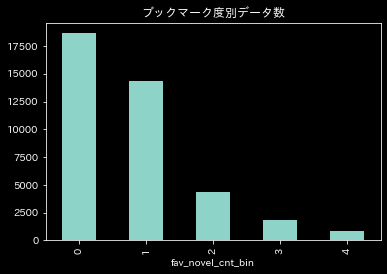

In [6]:
raw.groupby('fav_novel_cnt_bin').size().plot.bar(title='ブックマーク度別データ数');

### ・初回掲載年、経過日数カラム

チュートリアルを参考にして、経過日数カラムと初回掲載年カラムも追加しました。
テストデータが直近のものだけなので、除外も考えましたが、除外すると精度が低下したので残しています。

In [7]:
def firstup_prep(df):
    df = df.copy()
    # 掲載開始年
    df['gf_year'] = pd.to_datetime(df.general_firstup).apply(lambda x: x.year)
    # 経過日数カラム
    elapsed_days = lambda x: (base_date - datetime.datetime.strptime(x.split()[0], '%Y-%m-%d')).days
    # データをダウンロードした日をベース
    base_date = datetime.datetime(2021,9,29)
    df['elapsed_days'] = df.general_firstup.apply(elapsed_days)
    df.drop('general_firstup', axis=1, inplace=True)
    return df

In [8]:
df_train = firstup_prep(raw)
df_test = firstup_prep(raw_test)

### ・年ごとの投稿数と各ブックマーク分類の数

訓練データは直近のものがかなり多いようで、テストデータは直近のものだけです。

In [9]:
# テストデータは直近のもののみ
print(df_test.gf_year.unique())

[2021]


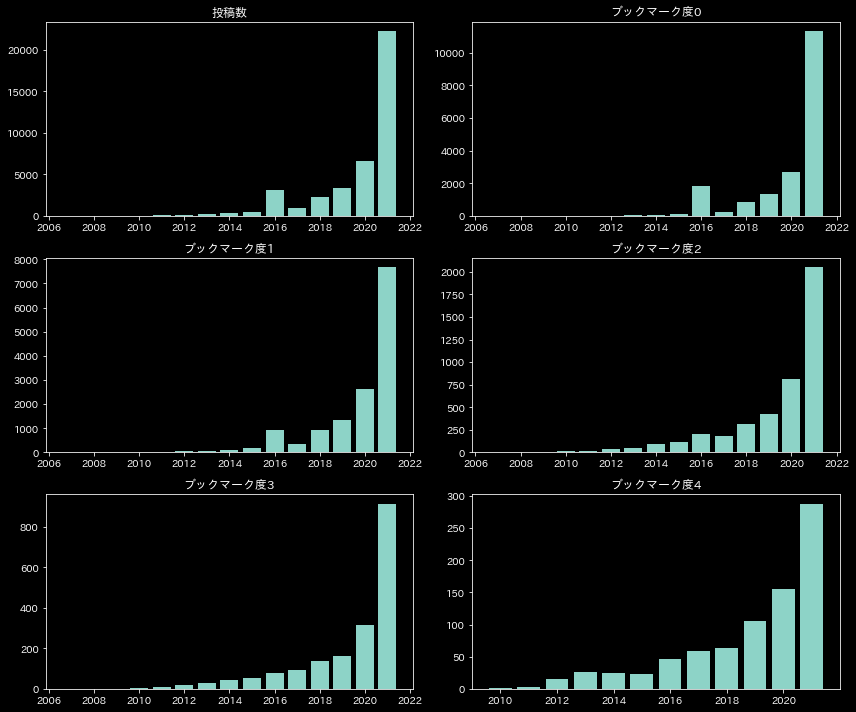

In [10]:
gb = df_train.groupby('gf_year')
gb0 = df_train[df_train.fav_novel_cnt_bin == 0].groupby('gf_year')
gb1 = df_train[df_train.fav_novel_cnt_bin == 1].groupby('gf_year')
gb2 = df_train[df_train.fav_novel_cnt_bin == 2].groupby('gf_year')
gb3 = df_train[df_train.fav_novel_cnt_bin == 3].groupby('gf_year')
gb4 = df_train[df_train.fav_novel_cnt_bin == 4].groupby('gf_year')

fig, ax = plt.subplots(3,2, figsize=(12,10))
ax[0,0].bar(gb.size().index, gb.size())
ax[0,0].set_title('投稿数');
ax[0,1].bar(gb0.size().index, gb0.size())
ax[0,1].set_title('ブックマーク度0');
ax[1,0].bar(gb1.size().index, gb1.size())
ax[1,0].set_title('ブックマーク度1');
ax[1,1].bar(gb2.size().index, gb2.size())
ax[1,1].set_title('ブックマーク度2');
ax[2,0].bar(gb3.size().index, gb3.size())
ax[2,0].set_title('ブックマーク度3');
ax[2,1].bar(gb4.size().index, gb4.size())
ax[2,1].set_title('ブックマーク度4')
plt.tight_layout();

### ・スパン別にデータ抽出

テストデータが直近のものだけなので、直近1, 2年のデータに絞ったモデルも作ることにました。

In [11]:
if (span == 365) | (span == 730):
    days = df_train.elapsed_days.unique().min() + span
    df_train = df_train[df_train.elapsed_days < days]
    df_train.reset_index(drop=True, inplace=True)

In [12]:
len(df_train)

40000

### ・トップトークンリスト作成

特定トークンが含まれていることでブックマーク度が上がる可能性があると仮定して、<br>
ブックマーク度が1以上のデータのトップトークンを特徴量化することにしました。<br>
（title:top200, story:top500, keyword:top200, 100-200-100と200-500-200の2パターンを試行）<br>
①各ブックマーク度別（1以上）にトップトークンを抽出<br>
②setでユニーク化<br>

In [13]:
# トークナイザをロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)

In [14]:
def text_normalize(text):
    # 文字列を正規化
    return unicodedata.normalize('NFKC', text)

In [15]:
def sharp_del(token_list):
    """##を消して連結"""
    count = 0
    for t in token_list:
        if '##' in t:
            count += 1
    while count > 0:
        for i in range(len(token_list)):
            if '##' in token_list[i]:
                token_list[i-1] = token_list[i-1] + token_list[i][2:]
                del token_list[i]
                count -= 1
                break
    return token_list

### （・スパンモデル2回目はここまで、カラムの絞り込みへ）

In [16]:
def make_token_list(df, col):
    """トークンリストを作成"""
    df = df.copy()
    token_list = []
    c = 0
     
    for i in range(len(df)):
        text = df[col].iloc[i]
        text = text_normalize(text)
        
        if col == 'story':
            text, url_count = URL_PATTERN.subn('URL', text)
            text, date_count = DATE_PATTERN.subn('DATE', text)

        if (col == 'title') | (col == 'story'):
            t = tokenizer.tokenize(text)
            t = sharp_del(t)
            # ユニーク化
            t = list(set(t))
            # '[UNK]'があれば削除
            if '[UNK]' in t:
                t.remove('[UNK]')
            for token in t:
                if len(token) >= 2:
                    token_list.append(token)
        
        if (col == 'keyword'):
            token_list += text.split()

        c += 1
        print(f'\r{c:5}', end='')
    return token_list

In [17]:
def make_token_dict(df, col):
    """トークン辞書を作成"""
    df = df.copy()
    for i in range(5):
        df_f = df[df.fav_novel_cnt_bin == i]
        token_list = make_token_list(df_f, col)
        if i == 0:
            token_dict = {i: (token_list)}
        else:
            token_dict[i] = token_list
        del df_f
    return token_dict

In [18]:
def make_top_token_list(token_dict, n):
    """トップトークンリストを作成"""
    top_token_dict = {}
    for i in range(5):
        counter = collections.Counter(token_dict[i])
        top = counter.most_common()[:n]
        temp_top_token_list = [i[0] for i in top]
        top_token_dict[i] = temp_top_token_list
    # ユニーク化
    top_token_list = list(set(top_token_dict[4]) | set(top_token_dict[3]) | 
                          set(top_token_dict[2]) | set(top_token_dict[1]))
    return sorted(top_token_list)

In [19]:
n_title = 200
title_token_dict = make_token_dict(df_train, 'title')
top_title_token_list = make_top_token_list(title_token_dict, n_title)
# データを保存
if span == 0:
    with open(BASE_DIR + f'top{n_title}_title_token_list.pkl', mode='wb') as f:
        pickle.dump(top_title_token_list, f)
if (span == 365) | (span == 730):
    with open(BASE_DIR + f'top{n_title}_title_token_list_{span}.pkl', mode='wb') as f:
        pickle.dump(top_title_token_list, f)

  814

In [20]:
n_story = 500
story_token_dict = make_token_dict(df_train, 'story')
top_story_token_list = make_top_token_list(story_token_dict, n_story)
# データを保存
if span == 0:
    with open(BASE_DIR + f'top{n_story}_story_token_list.pkl', mode='wb') as f:
        pickle.dump(top_story_token_list, f)
if (span == 365) | (span == 730):
    with open(BASE_DIR + f'top{n_story}_story_token_list_{span}.pkl', mode='wb') as f:
        pickle.dump(top_story_token_list, f)

  814

In [21]:
n_keyword = 200
keyword_token_dict = make_token_dict(df_train, 'keyword')
top_keyword_token_list = make_top_token_list(keyword_token_dict, n_keyword)
# データを保存
if span == 0:
    with open(BASE_DIR + f'top{n_keyword}_keyword_token_list.pkl', mode='wb') as f:
        pickle.dump(top_keyword_token_list, f)
if (span == 365) | (span == 730):
    with open(BASE_DIR + f'top{n_keyword}_keyword_token_list_{span}.pkl', mode='wb') as f:
        pickle.dump(top_keyword_token_list, f)

  814

### ・カラムの絞り込み

ncodeは重複がないためおそらく予測に影響ないと判断、writerはuseidと同等と判断しました。

In [22]:
df_train = df_train[['title', 'story', 'keyword', 'userid', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 
                     'isr15', 'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k', 'gf_year', 'elapsed_days',
                     'fav_novel_cnt_bin']
                   ].copy()
df_test = df_test[['title', 'story', 'keyword', 'userid', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 
                   'isr15', 'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k', 'gf_year', 'elapsed_days']
                 ].copy()

In [23]:
df_train.shape, df_test.shape

((40000, 19), (8522, 18))

### ・カウントカラム

チュートリアルを参考にして、storyカラムのURL数などを追加してカウントカラムを作成しました。

In [24]:
def make_count_columns(df, col):
    count_list = []
    url_count_list = []
    date_count_list = []
    len_text_list = []
    token_count_list = []
    
    for i in range(len(df)):
        text = df[col][i]
        # 文字列を正規化
        text = text_normalize(text)
        
        # storyのみURLとDATEを削除、カウント
        if col == 'story':
            text, url_count = URL_PATTERN.subn('', text)
            url_count_list.append(url_count)
            text, date_count = DATE_PATTERN.subn('', text)
            date_count_list.append(date_count)
        
        # テキストの長さ
        len_text_list.append(len(text))
        
        # トークンをカウント
        token_list = []
        if (col == 'title') | (col == 'story'):
            t = tokenizer.tokenize(text)
            t = sharp_del(t)
            for token in t:
                if len(token) >= 2:
                    token_list.append(token)
        if (col == 'keyword'):
            token_list = text.split()
        token_count_list.append(len(token_list))
        
        # 各種文字をカウント（ひらがな、カタカナ、英語、数字、漢字、絵文字）
        hira_j = ''.join(HIRAGANA_PATTERN.findall(text))
        kata_j = ''.join(KATAKANA_PATTERN.findall(text))
        eigo_j = ''.join(EIGO_PATTERN.findall(text))
        suuzi_j = ''.join(SUUZI_PATTERN.findall(text))
        kanzi_j = ''.join(KANZI_PATTERN.findall(text))
        emozi_j = ''.join(EMOZI_PATTERN.findall(text))
        count_list.append([len(hira_j), len(kata_j), len(eigo_j), len(suuzi_j), len(kanzi_j), len(emozi_j)])
        print(f'\r{i+1}', end='')
    
    print()
    if col == 'story':
        # storyのみurlとdateカウントカラム作成
        df['url_c'] = url_count_list
        df['date_c'] = date_count_list
        df['story_len_text'] = len_text_list
        df['story_token_c'] = token_count_list
    if (col == 'title') | (col == 'keyword'):
        df[f'{col}_len_text'] = len_text_list
        df[f'{col}_token_c'] = token_count_list
    
    columns = [f'{col}_hira_c', f'{col}_kata_c', f'{col}_eigo_c', f'{col}_suuzi_c', f'{col}_kanzi_c', f'{col}_emozi_c']
    df_count = pd.DataFrame(count_list, columns=columns)
    df = pd.concat([df, df_count], axis=1)
    
    return df

In [25]:
df_train = make_count_columns(df_train, 'title')
df_test = make_count_columns(df_test, 'title')

40000
8522


In [26]:
df_train = make_count_columns(df_train, 'story')
df_test = make_count_columns(df_test, 'story')

40000
8522


In [27]:
df_train = make_count_columns(df_train, 'keyword')
df_test = make_count_columns(df_test, 'keyword')

40000
8522


### ・トップトークンカラム

トップトークンリストをワンホットで特徴量化しました。

In [28]:
if span == 0:
    add = ''
if (span == 365) | (span == 730):
    add = f'_{span}'
with open(BASE_DIR + f'top200_title_token_list{add}.pkl', mode='rb') as f:
    top_title_token_list = pickle.load(f)
with open(BASE_DIR + f'top500_story_token_list{add}.pkl', mode='rb') as f:
    top_story_token_list = pickle.load(f)
with open(BASE_DIR + f'top200_keyword_token_list{add}.pkl', mode='rb') as f:
    top_keyword_token_list = pickle.load(f)

In [29]:
def make_df_top_token(df, col, top_token_list):
    df = df.copy()
    row_data_list = []
    c = 0

    for i in range(len(df)):
        text = df[col].iloc[i]
        text = text_normalize(text)
        if col == 'story':
            text = URL_PATTERN.sub('URL', text)
            text = DATE_PATTERN.sub('DATE', text)

        row_data = []
        for token in top_token_list:
            row_data.append(int(token in text))
        row_data_list.append(row_data)

        c += 1
        print(f'\r{c}', end='')
    print()
    
    df_top_token = pd.DataFrame(row_data_list)
    df_top_token.columns = [f'{col}_{str(i)}' for i in range(len(top_token_list))]
    
    return df_top_token

In [30]:
df_title_top_token = make_df_top_token(df_train, 'title', top_title_token_list)
df_test_title_top_token = make_df_top_token(df_test, 'title', top_title_token_list)

40000
8522


In [31]:
df_story_top_token = make_df_top_token(df_train, 'story', top_story_token_list)
df_test_story_top_token = make_df_top_token(df_test, 'story', top_story_token_list)

40000
8522


In [32]:
df_keyword_top_token = make_df_top_token(df_train, 'keyword', top_keyword_token_list)
df_test_keyword_top_token = make_df_top_token(df_test, 'keyword', top_keyword_token_list)

40000
8522


In [33]:
df_train.drop(['title', 'story', 'keyword'], axis=1, inplace=True)
df_test.drop(['title', 'story', 'keyword'], axis=1, inplace=True)

In [34]:
# 連結
df_train = pd.concat([df_train, df_title_top_token, df_story_top_token, df_keyword_top_token], 
                      axis=1)
df_test = pd.concat([df_test, df_test_title_top_token, df_test_story_top_token, df_test_keyword_top_token],  
                     axis=1)

### ・BERT特徴量カラム

BERT分類モデルを作ったものの、単独ではあまり精度が出なかった（loglossで0.9-1程度）ため、<br>
予測数値を特徴量として追加しました。（別ファイルで特徴量化）<br>
モデルは精度が向上した2モデル(whole,v2)を使っています。<br>

In [35]:
# whole
if span == 0:
    add = ''
if (span == 365) | (span == 730):
    add = f'_{span}'
with open(BASE_DIR + f'df_bert{add}_title.pkl', mode='rb') as f:
    df_bert_title = pickle.load(f)
with open(BASE_DIR + f'df_bert{add}_story.pkl', mode='rb') as f:
    df_bert_story = pickle.load(f)
with open(BASE_DIR + f'df_bert{add}_keyword.pkl', mode='rb') as f:
    df_bert_keyword = pickle.load(f)

with open(BASE_DIR + f'df_test_bert{add}_title.pkl', mode='rb') as f:
    df_test_bert_title = pickle.load(f)
with open(BASE_DIR + f'df_test_bert{add}_story.pkl', mode='rb') as f:
    df_test_bert_story = pickle.load(f)
with open(BASE_DIR + f'df_test_bert{add}_keyword.pkl', mode='rb') as f:
    df_test_bert_keyword = pickle.load(f)

# v2
with open(BASE_DIR + f'df_bert{add}_title_v2.pkl', mode='rb') as f:
    df_bert_title_v2 = pickle.load(f)
with open(BASE_DIR + f'df_bert{add}_story_v2.pkl', mode='rb') as f:
    df_bert_story_v2 = pickle.load(f)
with open(BASE_DIR + f'df_bert{add}_keyword_v2.pkl', mode='rb') as f:
    df_bert_keyword_v2 = pickle.load(f)

with open(BASE_DIR + f'df_test_bert{add}_title_v2.pkl', mode='rb') as f:
    df_test_bert_title_v2 = pickle.load(f)
with open(BASE_DIR + f'df_test_bert{add}_story_v2.pkl', mode='rb') as f:
    df_test_bert_story_v2 = pickle.load(f)
with open(BASE_DIR + f'df_test_bert{add}_keyword_v2.pkl', mode='rb') as f:
    df_test_bert_keyword_v2 = pickle.load(f)

In [36]:
# 連結
df_train = pd.concat([df_train, df_bert_title, df_bert_story, df_bert_keyword,
                      df_bert_title_v2, df_bert_story_v2, df_bert_keyword_v2, 
                     ], axis=1)
df_test = pd.concat([df_test, df_test_bert_title, df_test_bert_story, df_test_bert_keyword,
                     df_test_bert_title_v2, df_test_bert_story_v2, df_test_bert_keyword_v2,
                    ], axis=1)

### ・スパンモデル特徴量カラム（メインモデルのみ）

スパンモデル単独では精度が向上しなかったので、予測結果を特徴量化しました。

In [37]:
if span == 0:
    # cb
    with open(BASE_DIR + 'span_change_365_cb.pkl', mode='rb') as f:
        df_sc365_cb = pickle.load(f)
    with open(BASE_DIR + 'span_change_365_cb_test.pkl', mode='rb') as f:
        df_sc365_cb_test = pickle.load(f)
    with open(BASE_DIR + 'span_change_730_cb.pkl', mode='rb') as f:
        df_sc730_cb = pickle.load(f)
    with open(BASE_DIR + 'span_change_730_cb_test.pkl', mode='rb') as f:
        df_sc730_cb_test = pickle.load(f)
    # lgb
    with open(BASE_DIR + 'span_change_365_lgb.pkl', mode='rb') as f:
        df_sc365_lgb = pickle.load(f)
    with open(BASE_DIR + 'span_change_365_lgb_test.pkl', mode='rb') as f:
        df_sc365_lgb_test = pickle.load(f)
    with open(BASE_DIR + 'span_change_730_lgb.pkl', mode='rb') as f:
        df_sc730_lgb = pickle.load(f)
    with open(BASE_DIR + 'span_change_730_lgb_test.pkl', mode='rb') as f:
        df_sc730_lgb_test = pickle.load(f)
    
    # 足りない訓練データは0パディング
    # cb
    zeros_365_cb = pd.DataFrame(np.zeros((40000-len(df_sc365_cb), 5)), columns=df_sc365_cb.columns)
    zeros_730_cb = pd.DataFrame(np.zeros((40000-len(df_sc730_cb), 5)), columns=df_sc730_cb.columns)
    df_sc365_cb = zeros_365_cb.append(df_sc365_cb)
    df_sc730_cb = zeros_730_cb.append(df_sc730_cb)
    df_sc365_cb.reset_index(drop=True, inplace=True)
    df_sc730_cb.reset_index(drop=True, inplace=True)
    # lgb
    zeros_365_lgb = pd.DataFrame(np.zeros((40000-len(df_sc365_lgb), 5)), columns=df_sc365_lgb.columns)
    zeros_730_lgb = pd.DataFrame(np.zeros((40000-len(df_sc730_lgb), 5)), columns=df_sc730_lgb.columns)
    df_sc365_lgb = zeros_365_lgb.append(df_sc365_lgb)
    df_sc730_lgb = zeros_730_lgb.append(df_sc730_lgb)
    df_sc365_lgb.reset_index(drop=True, inplace=True)
    df_sc730_lgb.reset_index(drop=True, inplace=True)
#     print(df_train.shape, df_sc365_cb.shape, df_sc730_cb.shape, 
#           df_sc365_lgb.shape, df_sc730_lgb.shape)
#     print(df_test.shape, df_sc365_cb_test.shape, df_sc730_cb_test.shape, 
#           df_sc365_lgb_test.shape, df_sc730_lgb_test.shape)
    df_train = pd.concat([df_train, df_sc365_cb, df_sc730_cb, 
                          df_sc365_lgb, df_sc730_lgb, 
                          ], axis=1)
    df_test = pd.concat([df_test, df_sc365_cb_test, df_sc730_cb_test, 
                         df_sc365_lgb_test, df_sc730_lgb_test, 
                         ], axis=1)
    print(df_train.shape, df_test.shape)

(40000, 1436) (8522, 1435)


### 訓練データ作成

In [38]:
X = df_train.drop('fav_novel_cnt_bin', axis=1)
y = df_train[['fav_novel_cnt_bin']]

In [39]:
print(X.columns[:15])
if span == 0:
    print(X.columns[41:-49])
if (span == 365) | (span == 730):
    print(X.columns[41:-29])

Index(['userid', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15',
       'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k',
       'gf_year', 'elapsed_days'],
      dtype='object')
Index(['title_0', 'title_1', 'title_2', 'title_3', 'title_4', 'title_5',
       'title_6', 'title_7', 'title_8', 'title_9',
       ...
       'keyword_301', 'keyword_302', 'keyword_303', 'keyword_304',
       'keyword_305', 'keyword_306', 'keyword_307', 'keyword_308',
       'keyword_309', 'bert_title_0'],
      dtype='object', length=1345)


In [40]:
# カテゴリー特徴量指定
if span == 0:
    cat_features = X.columns[:14].tolist() + X.columns[41:-50].tolist()
if (span == 365) | (span == 730):
    cat_features = X.columns[:14].tolist() + X.columns[41:-30].tolist()

In [41]:
X.shape, y.shape

((40000, 1435), (40000, 1))

In [ ]:
"""
出力
0: ((40000, 1435), (40000, 1))
365: ((25453, 1514), (25453, 1))
730: ((30089, 1467), (30089, 1))
"""

### 訓練

In [42]:
loss_list = []
model_list = []
pred_list = []
val_index_list = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

if model_type == 'cb':
    params = {
            'random_seed': 42,
            'loss_function': 'MultiClass', 
            'verbose': 250, 
            'early_stopping_rounds': 100, 
    }
    for train_index, val_index in skf.split(X, y):
        val_index_list += list(val_index)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        c_train = cb.Pool(X_train, label=y_train, cat_features=cat_features)  
        c_val = cb.Pool(X_val, label=y_val, cat_features=cat_features)
        model = cb.CatBoostClassifier(**params)
        model.fit(c_train, eval_set=[c_val])
        pred = model.predict(c_val, prediction_type='Probability')
        loss = log_loss(y_val.values.reshape(-1), pred)
        loss_list.append(loss)
        model_list.append(model)
        pred_list.append(pred)
        print('==============================')
        print('log_loss:', loss)
        print('acc:', accuracy_score(y_val.values.reshape(-1), model.predict(c_val)))
        print('==============================')
    print('Done!')
    
if model_type == 'lgb':
    params = {
        'objective': 'multiclass',
        'num_classes': 5,
        'metric': 'multi_logloss',
        'num_leaves': 31,
        'max_depth': -1,
        "feature_fraction": 1,
        'learning_rate': 0.1,
        "boosting": "gbdt",
        "verbosity": -1,
        "random_state": 42,
        "num_boost_round": 1000,
        "early_stopping_rounds": 100
    }

    for train_index, val_index in skf.split(X, y):
        val_index_list += list(val_index)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        train_data = lgb.Dataset(X_train, label=y_train) 
        val_data = lgb.Dataset(X_val, label=y_val) 
        model = lgb.train(
            params,
            train_data, 
            categorical_feature = cat_features,
            valid_names = ['train', 'valid'],
            valid_sets =[train_data, val_data], 
            verbose_eval = 100,
        )
        pred = model.predict(X_val, num_iteration=model.best_iteration)
        loss = log_loss(y_val.values, pred)
        model_list.append(model)
        pred_list.append(pred)
        loss_list.append(loss)
    print('Done!')

Learning rate set to 0.115726
0:	learn: 1.4363021	test: 1.4384730	best: 1.4384730 (0)	total: 384ms	remaining: 6m 23s
250:	learn: 0.6484555	test: 0.7043561	best: 0.7043561 (250)	total: 1m 1s	remaining: 3m 2s
500:	learn: 0.5923202	test: 0.7040000	best: 0.7036487 (465)	total: 2m 2s	remaining: 2m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7036487271
bestIteration = 465

Shrink model to first 466 iterations.
log_loss: 0.7036487270887369
acc: 0.692375
Learning rate set to 0.115726
0:	learn: 1.4346309	test: 1.4373754	best: 1.4373754 (0)	total: 246ms	remaining: 4m 6s
250:	learn: 0.6454659	test: 0.7077727	best: 0.7077452 (249)	total: 1m 3s	remaining: 3m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7066534962
bestIteration = 300

Shrink model to first 301 iterations.
log_loss: 0.7066534961589627
acc: 0.691875
Learning rate set to 0.115726
0:	learn: 1.4365984	test: 1.4366461	best: 1.4366461 (0)	total: 255ms	remaining: 4m 14s
250:	learn: 0.6

In [43]:
print(np.array(loss_list).round(4))
print(np.array(loss_list).mean().round(4))

[0.7036 0.7067 0.7023 0.7023 0.7046]
0.7039


In [ ]:
"""
365_cb: 0.6669
365_lgb: 0.726
730_cb: 0.6783
730_lgb: 0.7342
main: 0.7039
"""

### ・評価（参考：最終モデルのみ）

In [44]:
print(classification_report(y_val.values.reshape(-1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      3729
           1       0.64      0.64      0.64      2872
           2       0.51      0.45      0.48       864
           3       0.49      0.38      0.43       372
           4       0.67      0.40      0.51       163

    accuracy                           0.69      8000
   macro avg       0.62      0.54      0.57      8000
weighted avg       0.69      0.69      0.69      8000



### ・特徴量重要度

In [45]:
if model_type == 'cb':
    importances = pd.DataFrame({'feature_name': model.feature_names_,  
                                'feature_importance': model.feature_importances_})
if model_type == 'lgb':
    importances = pd.DataFrame({'feature_name': model.feature_name(), 
                            'feature_importance': model.feature_importance()})
importances.sort_values('feature_importance', ascending=False)[:30]

,feature_name,feature_importance
0,userid,9.229134
1420,sc730_cb_0,6.764173
1421,sc730_cb_1,6.468757
3,novel_type,4.305674
1422,sc730_cb_2,2.530626
1393,bert_story_3,2.360857
1412,bert_keyword_v2_2,2.155884
1416,sc365_cb_1,1.889977
1430,sc730_lgb_0,1.865310
1423,sc730_cb_3,1.832653


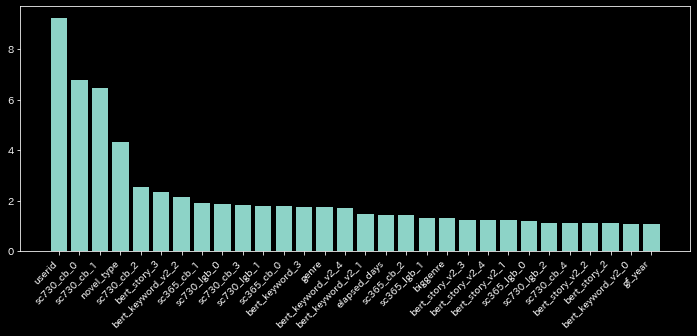

In [46]:
# 特徴量重要度上位をグラフ化
fig, ax = plt.subplots(figsize=(12,5))
temp = importances.sort_values('feature_importance', ascending=False)[:30]
ax.bar(temp.feature_name, temp.feature_importance)
fig.autofmt_xdate(rotation=45)

### ・モデル出力の特徴量化（スパンモデルのみ）

In [40]:
if (span == 365) | (span == 730):
    df_features = pd.DataFrame()
    for l in pred_list:
        df_features = df_features.append(pd.DataFrame(l))
    df_features.index = val_index_list
    df_features.sort_index(inplace=True)
    df_features.columns = [f'sc{span}_{model_type}_{i}'for i in range(5)]
    with open(BASE_DIR + f'span_change_{span}_{model_type}.pkl', mode='wb') as f:
        pickle.dump(df_features, f)

### テストデータ予測

In [41]:
test_pred_list = []
if model_type == 'cb':
    df_test_cb = df_test.copy()
    df_test_cb.columns = X.columns
    c_test = cb.Pool(df_test_cb, cat_features=cat_features)
    for model in model_list:
        predict = model.predict(c_test, prediction_type='Probability')
        test_pred_list.append(predict)
if model_type == 'lgb':
    for model in model_list:
        pred = model.predict(df_test, num_iteration=model.best_iteration)
        test_pred_list.append(pred)

In [42]:
sub_pred_list = []
for i in range(len(test_pred_list[0])):
    sub_pred_list.append(np.array(test_pred_list)[:, i, :].mean(axis=0))

In [43]:
df_sub_pred = pd.DataFrame(sub_pred_list)

In [44]:
df_sub_pred.shape

(8522, 5)

### ・テストデータ予測値の特徴量化（スパンモデルのみ、スパンモデルはここまで）

In [45]:
if (span == 365) | (span == 730):
    df_sub_pred.columns = [f'sc{span}_{model_type}_test_{i}'for i in range(5)]
    with open(BASE_DIR + f'span_change_{span}_{model_type}_test.pkl', mode='wb') as f:
        pickle.dump(df_sub_pred, f)

### 提出

In [55]:
sub = pd.read_csv(BASE_DIR + 'sample_submission.csv')
len(sub), sub.head()

(8522,
      ncode  proba_0  proba_1  proba_2  proba_3  proba_4
 0  N4541HD        0        0        0        0        0
 1  N4397HD        0        0        0        0        0
 2  N4544HD        0        0        0        0        0
 3  N4545HD        0        0        0        0        0
 4  N4546HD        0        0        0        0        0)

In [56]:
for i, col in enumerate(sub.columns[1:]):
    sub[col] = df_sub_pred.iloc[:, i]

In [57]:
sub

,ncode,proba_0,proba_1,proba_2,proba_3,proba_4
0,N4541HD,0.842168,0.154572,0.002959,0.000274,0.000026
1,N4397HD,0.009502,0.292042,0.546428,0.141835,0.010193
2,N4544HD,0.879149,0.119995,0.000780,0.000070,0.000005
3,N4545HD,0.057220,0.587155,0.274673,0.054573,0.026378
4,N4546HD,0.131434,0.851928,0.016282,0.000335,0.000021
...,...,...,...,...,...,...
8517,N5983HF,0.734231,0.263588,0.002024,0.000146,0.000011
8518,N5990HF,0.731636,0.263830,0.004115,0.000399,0.000021
8519,N5993HF,0.867958,0.129937,0.001867,0.000225,0.000014
8520,N5996HF,0.702024,0.289314,0.007860,0.000723,0.000079


In [62]:
sub.to_csv(BASE_DIR + 'submission.csv', index=False)